# Dataproject: Electricity prices and consumption in Denmark

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import datetime 


# Introduction to data project 

This project focuses on analyzing the Danish electricity market, which has experienced rising electricity prices, leading to a growing interest in this market. Unlike other markets, the electricity market operates uniquely as electricity is traded hourly on the exchange and exhibits significant fluctuations based on the specific time of day, week, and year.

# Read and clean data

We have two datasets: "Elspotprices.csv" and "ConsumptionDE35Hour.csv". In "Elspotprices.csv" we got data on the hourly electricity price in different price areas in Denmark, Germany, Sweden and Norway in March 2023. Note: the electricity price is without taxes and tariffs, and can sometimes be negative if supply is much larger than demand. In "ConsumptionDE35Hour.csv" we got hourly electricity consumption for different sectors/industries in March 2023 

In [2]:
Elprice = pd.read_csv("Elspotprices.csv", delimiter=';') 
Consumption= pd.read_csv("ConsumptionDE35Hour.csv", delimiter=';')
#Inspect the first 5 rows of the dataset
Elprice.head(5)


,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2023-03-30 21:00,2023-03-30 23:00,DE,"676,190002","90,760002"
1,2023-03-30 21:00,2023-03-30 23:00,DK1,"676,190002","90,760002"
2,2023-03-30 21:00,2023-03-30 23:00,DK2,"447,239990","60,029999"
3,2023-03-30 21:00,2023-03-30 23:00,NO2,"689,450012","92,540001"
4,2023-03-30 21:00,2023-03-30 23:00,SE3,"256,140015","34,380001"


We only want to look at PriceArea DK1. We don't want the time-variable "HourUTC" since we also have the time-variable "HourDK". We don't want the electricity price in EUR since we also have it in DKK.

In [3]:
Consumption_DK1 = Consumption.loc[Consumption['PriceArea'] == 'DK1', :]
Elprice_DK1=Elprice.loc[Elprice['PriceArea'] == 'DK1', :]
#Drop HourUTC from both datasets
Consumption_DK1 = Consumption_DK1.drop(columns=['HourUTC'])
Elprice_DK1 = Elprice_DK1.drop(columns=['HourUTC','SpotPriceEUR'])
#Inspect the first 5 rows of the dataset
Elprice_DK1.head(5)

,HourDK,PriceArea,SpotPriceDKK
1,2023-03-30 23:00,DK1,"676,190002"
8,2023-03-30 22:00,DK1,"735,570007"
15,2023-03-30 21:00,DK1,"763,289978"
22,2023-03-30 20:00,DK1,"867,960022"
29,2023-03-30 19:00,DK1,"891,809998"


We only want to look at three different consumer types: 122, 350 and 421.
122 is "Single Family Homes and similar with electric heating", 350 is "Chemical industry" and 421 is "Retail". We also rename the consumption variable to "C122","C350" and "C421"  

In [4]:
#Locate the consumer type 122
Consumption_DK1_122 = Consumption_DK1.loc[Consumption_DK1["ConsumerType_DE35"] == 122, :].copy()
#Rename 122
Consumption_DK1_122.rename(columns={'TotalCon': 'C122'}, inplace=True)

#Locate the consumer type 350
Consumption_DK1_350 = Consumption_DK1.loc[Consumption_DK1["ConsumerType_DE35"] == 350, :].copy()
#Rename 350
Consumption_DK1_350.rename(columns={'TotalCon': 'C350'}, inplace=True)

#Locate the consumer type 421
Consumption_DK1_421 = Consumption_DK1.loc[Consumption_DK1["ConsumerType_DE35"] == 421, :].copy()
#Rename 421
Consumption_DK1_421.rename(columns={'TotalCon': 'C421'}, inplace=True)
#Inspect the first 5 rows of the dataset
Consumption_DK1_421.head(5)

,HourDK,PriceArea,ConsumerType_DE35,C421
44,2023-03-30 23:00,DK1,421,58557
120,2023-03-30 22:00,DK1,421,61945
196,2023-03-30 21:00,DK1,421,70620
272,2023-03-30 20:00,DK1,421,80722
348,2023-03-30 19:00,DK1,421,88791


Now that we have extracted the consumer types and the Price Area we want, we don't need the variables "PriceArea" and "ConsumerType_DE35" anymore 

In [5]:
#Drop "PriceArea" and "ConsumerType_DE35"
Elprice_DK1 = Elprice_DK1.drop(columns=['PriceArea'])
Consumption_DK1_122 = Consumption_DK1_122.drop(columns=['PriceArea', "ConsumerType_DE35"])
Consumption_DK1_350 = Consumption_DK1_350.drop(columns=['PriceArea',  "ConsumerType_DE35"])
Consumption_DK1_421 = Consumption_DK1_421.drop(columns=['PriceArea', "ConsumerType_DE35"])
Consumption_DK1_421.head(5)

,HourDK,C421
44,2023-03-30 23:00,58557
120,2023-03-30 22:00,61945
196,2023-03-30 21:00,70620
272,2023-03-30 20:00,80722
348,2023-03-30 19:00,88791


We now got 4 dataframes. Consumption in 3 different sectors and the the electricity price. We want "HourDK" to be a datetime varible so we use the function "pd.to_datetime" in each dataframe 

In [6]:
#Define "HourDK" as a datetime variable in for the three types 122, 350 and 421
Consumption_DK1_122['HourDK'] = pd.to_datetime(Consumption_DK1_122['HourDK'])
Consumption_DK1_350['HourDK'] = pd.to_datetime(Consumption_DK1_350['HourDK'])
Consumption_DK1_421['HourDK'] = pd.to_datetime(Consumption_DK1_421['HourDK'])
Elprice_DK1['HourDK'] = pd.to_datetime(Elprice_DK1['HourDK'])

We now got the prolem that the electricity price 'SpotPriceDKK' is a string variable with the Danish decimal separator "," indstead of the English "." We first use the "replace" function to replace "," with ".", and then convert the string to a float called "float_price". Finally we merge the "float_price" to the dataframe "Elprice_DK1". 

In [7]:
 
p = Elprice_DK1['SpotPriceDKK'].values 
# Replace commas with periods
string_price = [i.replace(',', '.') for i in p]
# Convert string vector to float vector
float_price = list(map(float, string_price))


# reset index for elprice in order to merge dataset 
Elprice_DK1 = Elprice_DK1.reset_index(drop=True)

Elprice_DK1  = pd.concat([Elprice_DK1, pd.DataFrame(float_price, columns=['float_price'])], axis=1)
Elprice_DK1.head(5)




,HourDK,SpotPriceDKK,float_price
0,2023-03-30 23:00:00,"676,190002",676.190002
1,2023-03-30 22:00:00,"735,570007",735.570007
2,2023-03-30 21:00:00,"763,289978",763.289978
3,2023-03-30 20:00:00,"867,960022",867.960022
4,2023-03-30 19:00:00,"891,809998",891.809998


# Merge data sets

We are now ready to merge our 4 datasets in one dataset called "merged"

In [8]:
#Make an inner merge
merged = pd.merge(Elprice_DK1, Consumption_DK1_122, on='HourDK')
merged = pd.merge(merged, Consumption_DK1_350, on='HourDK')
merged = pd.merge(merged, Consumption_DK1_421, on='HourDK')
merged.head(5)

,HourDK,SpotPriceDKK,float_price,C122,C350,C421
0,2023-03-30 23:00:00,"676,190002",676.190002,54446,53862,58557
1,2023-03-30 22:00:00,"735,570007",735.570007,58260,55280,61945
2,2023-03-30 21:00:00,"763,289978",763.289978,61721,56068,70620
3,2023-03-30 20:00:00,"867,960022",867.960022,64185,56872,80722
4,2023-03-30 19:00:00,"891,809998",891.809998,66587,57098,88791


# Analysis

To get a quick overview of the data, we show some **summary statistics**. We got 719 observations. The average electricity price was 737 DKK per mWh. The lowest price was -8.79 DKK per mWh and the highest was 1615 DKK per mWh. The average electricity consumption is highest in "retail" (C421)

In [9]:
merged.describe()

,float_price,C122,C350,C421
count,719.000000,719.000000,719.000000,719.000000
mean,737.231155,63911.684284,48510.272601,86906.022253
std,285.355386,10866.431126,9761.438821,25972.484668
min,-8.790000,38630.000000,29846.000000,50517.000000
25%,613.285003,55341.000000,39104.500000,61234.000000
50%,747.330017,63086.000000,47370.000000,83970.000000
75%,896.700012,70807.500000,56064.500000,112789.500000
max,1615.810059,98103.000000,71828.000000,134336.000000


In Figure 1 we plot electricity consumption in the 3 sectors for every hour in March 2023. Electricity consumption fluctuates relativly much, but takes a predictable pattern, which could be due to the time of the day and the day of the week. Again we have that consumption is highest in "Retail". 

In [10]:
def plot_electricity_consumption(Consumer_type):
    plt.figure(figsize=(13,5))
    plt.plot(merged['HourDK'], merged[Consumer_type])
    plt.title('Figure 1 Electricity consumption of counsumer type '+ Consumer_type)
    plt.xlabel('Hour')
    plt.ylabel('Electricity consumption in kWh')
    plt.show()

Consumer_type = widgets.Dropdown(
    options=['C122', 'C350', 'C421'],
    value='C122',
    description='Type',
)

widgets.interactive(plot_electricity_consumption, Consumer_type=Consumer_type)

interactive(children=(Dropdown(description='Type', options=('C122', 'C350', 'C421'), value='C122'), Output()),…

In Figure 2 we show the electricity price for every hour in March 2023. The electricity price tends to be higher in the first half of the month than the second. We also see that the price doesn´t follow the same predictable pattern as consumption.  

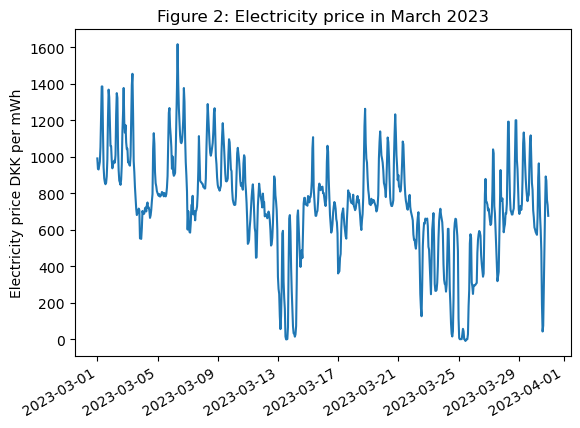

In [11]:
#Define the plot
merged.plot(x="HourDK",y="float_price",legend=False);
# Add labels and title
plt.xlabel('')
plt.ylabel('Electricity price DKK per mWh')
plt.title('Figure 2: Electricity price in March 2023')

# Display the plot
plt.show()

In figure 3 we show the hourly mean of electricity Consumption. We use the "groupby" and "dt.hour" functions to calculate the mean of consumption for every hour of the day. From the plot it appears that "singe family homes" use most electricity in the morning 5-8 pm and evning 4-7 am. In "Chemical industry" and "retail" consumption is highest in the daytime 8 pm - 3 am. 

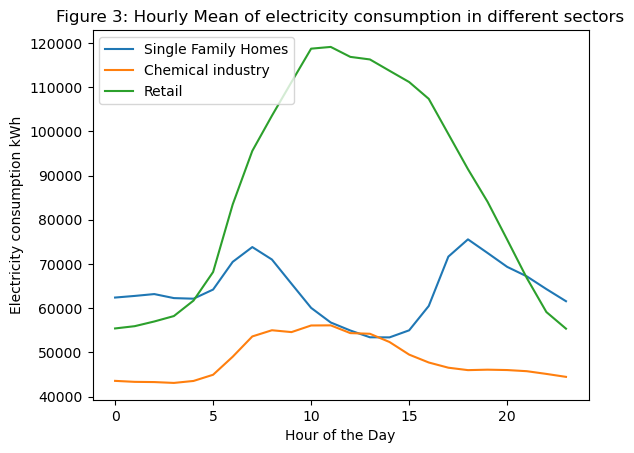

In [12]:
#Create figure
fig, ax = plt.subplots()
for var in ['C122', 'C350', 'C421']:
    # Calculate hourly means for consumption
    means = merged.groupby(merged['HourDK'].dt.hour)[var].mean()
    # Plot variable
    ax.plot(means.index, means.values, label=var)

# Set the plot title and axis labels
ax.set_title('Figure 3: Hourly Mean of electricity consumption in different sectors')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Electricity consumption kWh')
plt.legend(["Single Family Homes", "Chemical industry", "Retail"])

# Show the plot
plt.show()

In figure 4 we show the hourly mean of the electricity price. We use the same approach to generate the plot as in figure 3. The electricity price is higher in the morning 5-8 pm and evening 4-7 am, where demand is higher.  

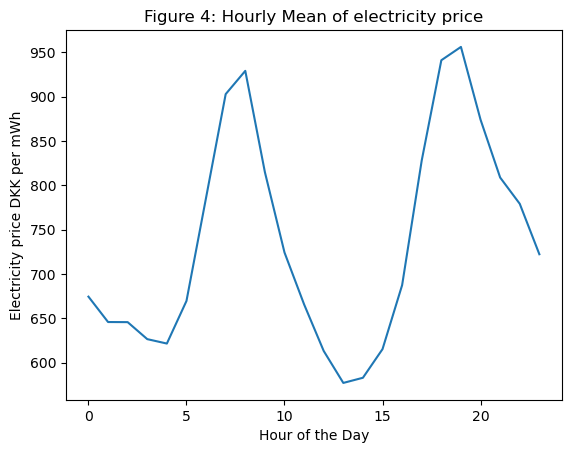

In [13]:
#Calculate mean of price for every hour 
hourly_mean_price = merged.groupby(merged['HourDK'].dt.hour)['float_price'].mean()
# Plot the hourly mean values
fig, ax = plt.subplots()
ax.plot(hourly_mean_price.index, hourly_mean_price.values)
# Set the plot title and axis labels
ax.set_title('Figure 4: Hourly Mean of electricity price')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Electricity price DKK per mWh')
# Show the plot
plt.show()


In Figure 5 we show the mean of electricity consumption by day of week. We use the "dayofweek" function to do this. We see that electricity consumption is lower in the weekend for "Chemical industry" and "retail". 

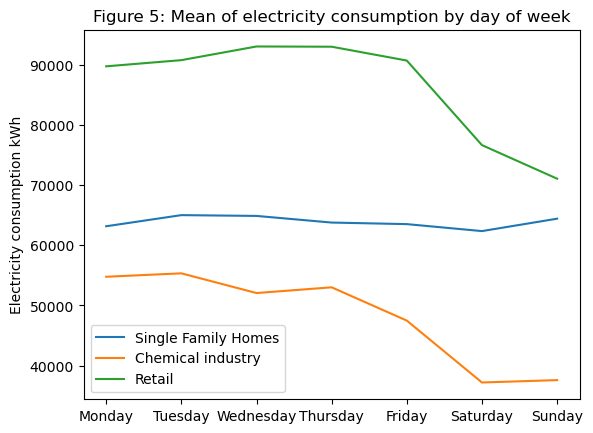

In [14]:
#Create figure
fig, ax = plt.subplots()
for var in ['C122', 'C350', 'C421']:
    # Calculate mean consumption for every day of week
    means = merged.groupby(merged['HourDK'].dt.dayofweek)[var].mean()
    # Plot variable
    ax.plot(means.index, means.values, label=var)
# Create a list of weekday names
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Set the plot title and axis labels
ax.set_title('Figure 5: Mean of electricity consumption by day of week')
ax.set_xticks(range(len(weekday_names)))
ax.set_xticklabels(weekday_names)   
ax.set_ylabel('Electricity consumption kWh')
plt.legend(["Single Family Homes", "Chemical industry", "Retail"])

# Show the plot
plt.show()

In Figure 6 we plot the mean of the electricity price by day of the week. We see that the electricity price is lower in the weekend.  

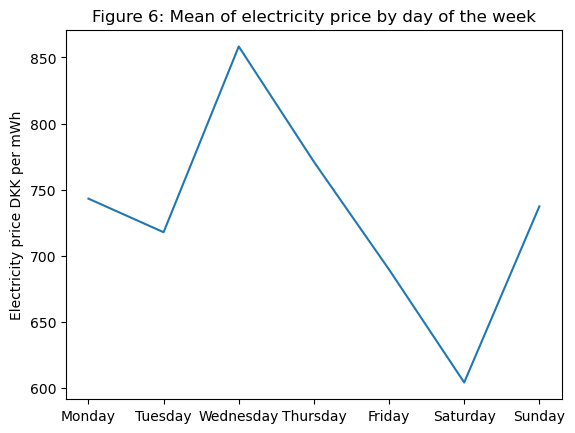

In [15]:
#Calculate mean of price for every day of week 
dayofweek_mean_price = merged.groupby(merged['HourDK'].dt.dayofweek)['float_price'].mean()
# Plot the hourly mean values
fig, ax = plt.subplots()
ax.plot(weekday_names, dayofweek_mean_price.values)
# Set the plot title and axis labels
ax.set_title('Figure 6: Mean of electricity price by day of the week')
ax.set_ylabel('Electricity price DKK per mWh')
# Show the plot
plt.show()

# Conclusion

In this project we have looked at electricity consumption and the electricity price in Denmark. "Singe family homes" use more electricity in the morning 5-8 pm and evening 4-7 am. In "Chemical industry" and "retail" consumption is highest in the daytime 8 pm -3 am. The average electricity price was 737 DKK per mWh. The lowest price was -8.79 DKK per mWh and the highest was 1615 DKK per mWh. The electricity price doesn´t follow the same predictable pattern as consumption.